## 🧩 Step 1 — Import Required Libraries
This section imports all the necessary Python libraries used throughout the project.  
It includes:
- Core Python libraries for file handling  
- Data analysis and visualization tools  
- PyTorch and torchvision for deep learning  
- Warnings handling to keep logs clean

##  Environment Setup (for all collaborators)

Before running this notebook, make sure that **PyTorch** and related libraries are installed.  
We’re using the **CPU version** (no GPU required) to ensure compatibility for everyone.

###  Installation command (run this only once)

```bash
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [1]:
#  Kaoutar : Setup and  Imports 

# Core
import os
import shutil
import random
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from PIL import Image
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Warnings
import warnings
warnings.filterwarnings("ignore")

print(" Libraries imported successfully.")


 Libraries imported successfully.


##  Step 2 — Data Loading & Cleaning

In this section, we will:
- Load image paths from the **raw dataset**
- Verify that each image has a valid extension (`.jpg`, `.jpeg`, `.bmp`, `.png`)
- Handle loading errors with a `try/except` block
- Save successfully verified images into the directory: `data/cleaned/`

This ensures that only valid and readable images are used for training, avoiding issues later during model loading.


### Dataset Instructions

Download the dataset for this project (Blood_Cells_Cancer),  
extract it, and place it in:

data/raw/


In [2]:
#  Kaoutar : Dataset Loading and  Cleaning

# Define input raw and output (cleaned) directories
raw_data_path = Path("../data/raw/Blood_Cells_Cancer/Blood cell Cancer [ALL]")
cleaned_data_path = Path("../data/cleaned")

# Create output folder if it doesn't exist
cleaned_data_path.mkdir(parents=True, exist_ok=True)

# Valid image extensions
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

print(" Raw data path:", raw_data_path)
print(" Cleaned data path:", cleaned_data_path)
print(" Folder structure ready.")


 Raw data path: ..\data\raw\Blood_Cells_Cancer\Blood cell Cancer [ALL]
 Cleaned data path: ..\data\cleaned
 Folder structure ready.


###  Clean and Copy Valid Images

Below, we loop through each class folder (each represents a cancer cell type).  
For each image:
- We check if the file extension is valid  
- We attempt to open it with PIL (inside a `try/except` block)  
- If the image opens successfully, we copy it into the `data/cleaned` directory  
- Otherwise, we skip it and print a warning message


In [3]:
# Loop through each class folder in the raw dataset
for class_name in os.listdir(raw_data_path):
    class_path = raw_data_path / class_name
    
    # Skip non-directory files
    if not class_path.is_dir():
        continue
    
    # Create corresponding class folder in cleaned dataset
    target_class_path = cleaned_data_path / class_name
    target_class_path.mkdir(parents=True, exist_ok=True)
    
    print(f" Processing class: {class_name}")
    
    for image_name in os.listdir(class_path):
        image_path = class_path / image_name
        ext = image_path.suffix.lower()
        
        # Skip invalid extensions
        if ext not in valid_extensions:
            print(f" Skipping invalid file: {image_name}")
            continue
        
        # Try to open the image
        try:
            with Image.open(image_path) as img:
                img.verify()  # verify ensures the file is not corrupted
                
            # Copy valid image to cleaned folder
            shutil.copy(image_path, target_class_path)
        
        except Exception as e:
            print(f" Error loading {image_name}: {e}")
            continue

print(" Dataset cleaning complete. Cleaned data stored in /data/cleaned/")


 Processing class: Benign
 Processing class: early Pre-B
 Processing class: Pre-B
 Processing class: Pro-B
 Dataset cleaning complete. Cleaned data stored in /data/cleaned/


REDA START HERE THE COUNT :

Saved class counts to: ..\results\class_counts.csv


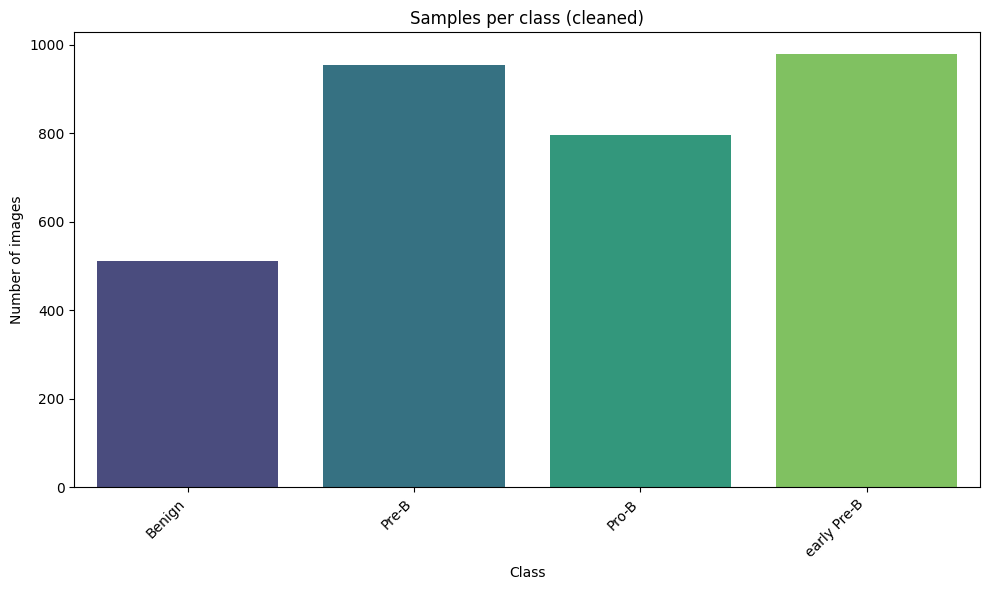

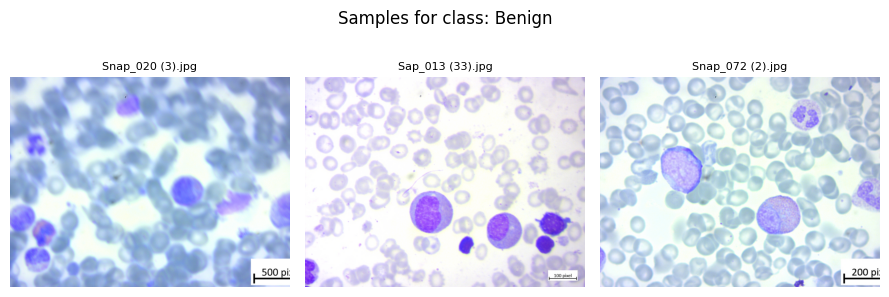

Saved sample montage for 'Benign' -> ..\results\samples_Benign.png


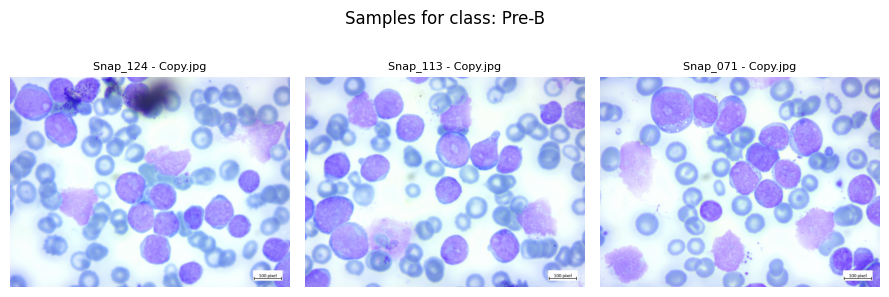

Saved sample montage for 'Pre-B' -> ..\results\samples_Pre-B.png


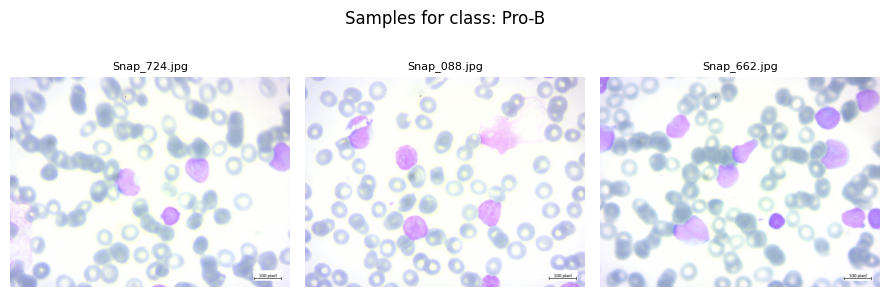

Saved sample montage for 'Pro-B' -> ..\results\samples_Pro-B.png


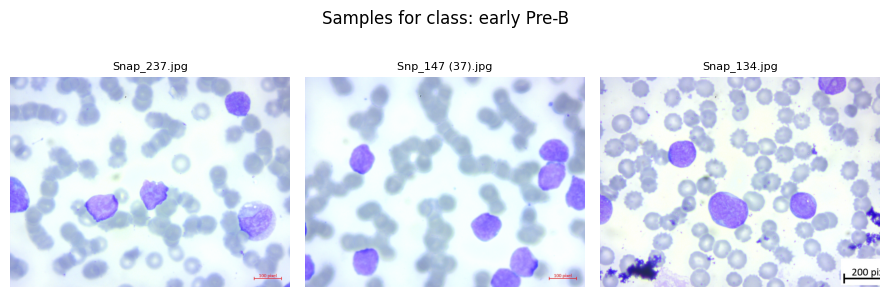

Saved sample montage for 'early Pre-B' -> ..\results\samples_early_Pre-B.png
Saved class counts to: ..\results\class_counts.csv


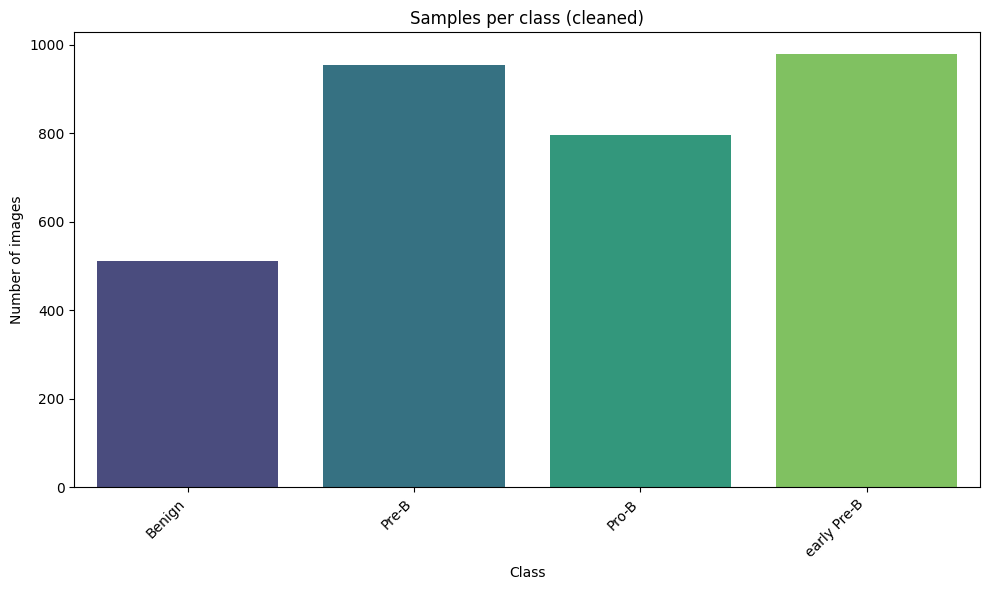

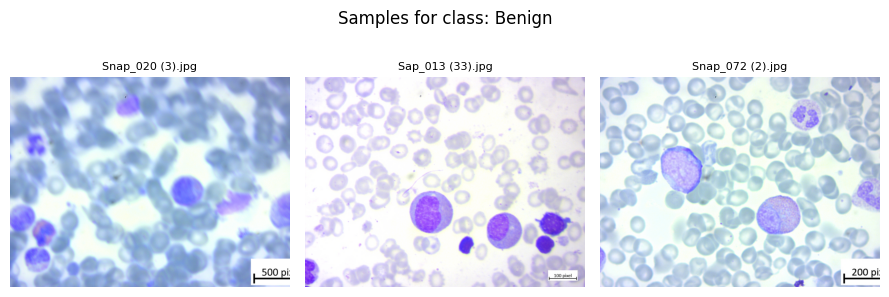

Saved sample montage for 'Benign' -> ..\results\samples_Benign.png


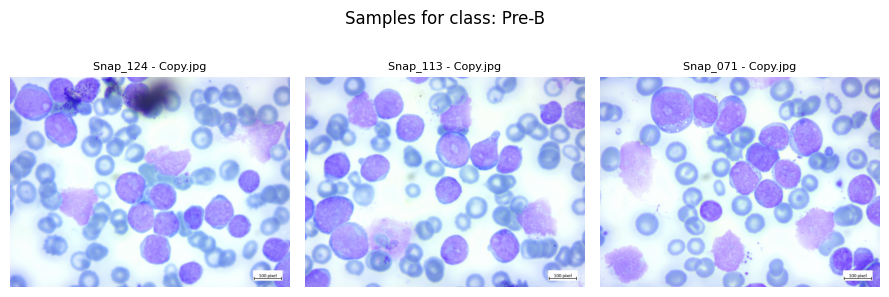

Saved sample montage for 'Pre-B' -> ..\results\samples_Pre-B.png


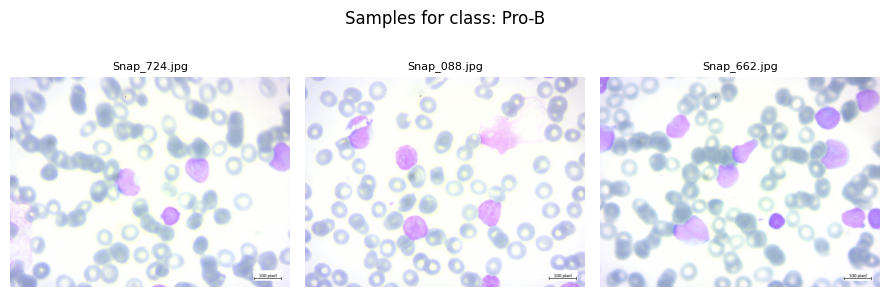

Saved sample montage for 'Pro-B' -> ..\results\samples_Pro-B.png


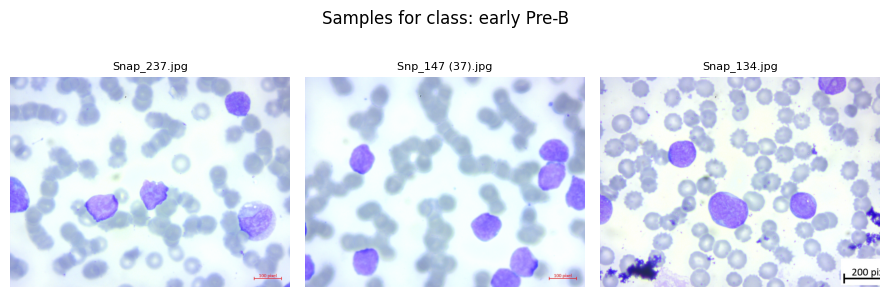

Saved sample montage for 'early Pre-B' -> ..\results\samples_early_Pre-B.png


In [4]:

# Dataset exploration (counts + sample images) — run after cleaning

from pathlib import Path
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

random.seed(42)

cleaned_data_path = Path("../data/cleaned")
results_path = Path("../results")
results_path.mkdir(parents=True, exist_ok=True)

if not cleaned_data_path.exists():
    print(f"Cleaned data folder not found: {cleaned_data_path}")
else:
    # collect (class, path)
    records = []
    for class_dir in sorted([d for d in cleaned_data_path.iterdir() if d.is_dir()]):
        for p in class_dir.iterdir():
            if p.is_file():
                records.append({"class": class_dir.name, "path": str(p)})

    if not records:
        print("No images found in cleaned dataset.")
    else:
        df = pd.DataFrame(records)

        # counts per class -> CSV + barplot
        counts = df['class'].value_counts().sort_index()
        counts_df = counts.reset_index()
        counts_df.columns = ['class', 'count']
        counts_df.to_csv(results_path / "class_counts.csv", index=False)
        print(f"Saved class counts to: {results_path / 'class_counts.csv'}")

        plt.figure(figsize=(10,6))
        sns.barplot(data=counts_df, x='class', y='count', palette='viridis')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Number of images")
        plt.xlabel("Class")
        plt.title("Samples per class (cleaned)")
        plt.tight_layout()
        plt.savefig(results_path / "class_counts.png")
        plt.show()

        # show up to 3 sample images per class and save each class montage
        samples_per_class = 3
        for cls in counts_df['class'].tolist():
            img_paths = df[df['class'] == cls]['path'].tolist()
            if not img_paths:
                continue
            chosen = random.sample(img_paths, min(len(img_paths), samples_per_class))

            fig, axes = plt.subplots(1, len(chosen), figsize=(3*len(chosen), 3))
            if len(chosen) == 1:
                axes = [axes]
            for ax, p in zip(axes, chosen):
                try:
                    img = Image.open(p).convert("RGB")
                    ax.imshow(img)
                    ax.axis("off")
                    ax.set_title(Path(p).name, fontsize=8)
                except Exception as e:
                    ax.axis("off")
                    ax.set_title("error", fontsize=8)
                    print(f"Could not open {p}: {e}")
            plt.suptitle(f"Samples for class: {cls}", y=1.02)
            plt.tight_layout()
            out_file = results_path / f"samples_{cls.replace(' ', '_')}.png"
            plt.savefig(out_file, bbox_inches='tight')
            plt.show()
            print(f"Saved sample montage for '{cls}' -> {out_file}")


from pathlib import Path
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

random.seed(42)

cleaned_data_path = Path("../data/cleaned")
results_path = Path("../results")
results_path.mkdir(parents=True, exist_ok=True)

if not cleaned_data_path.exists():
    print(f"Cleaned data folder not found: {cleaned_data_path}")
else:
    # collect (class, path)
    records = []
    for class_dir in sorted([d for d in cleaned_data_path.iterdir() if d.is_dir()]):
        for p in class_dir.iterdir():
            if p.is_file():
                records.append({"class": class_dir.name, "path": str(p)})

    if not records:
        print("No images found in cleaned dataset.")
    else:
        df = pd.DataFrame(records)

        # counts per class -> CSV + barplot
        counts = df['class'].value_counts().sort_index()
        counts_df = counts.reset_index()
        counts_df.columns = ['class', 'count']
        counts_df.to_csv(results_path / "class_counts.csv", index=False)
        print(f"Saved class counts to: {results_path / 'class_counts.csv'}")

        plt.figure(figsize=(10,6))
        sns.barplot(data=counts_df, x='class', y='count', palette='viridis')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Number of images")
        plt.xlabel("Class")
        plt.title("Samples per class (cleaned)")
        plt.tight_layout()
        plt.savefig(results_path / "class_counts.png")
        plt.show()

        # show up to 3 sample images per class and save each class montage
        samples_per_class = 3
        for cls in counts_df['class'].tolist():
            img_paths = df[df['class'] == cls]['path'].tolist()
            if not img_paths:
                continue
            chosen = random.sample(img_paths, min(len(img_paths), samples_per_class))

            fig, axes = plt.subplots(1, len(chosen), figsize=(3*len(chosen), 3))
            if len(chosen) == 1:
                axes = [axes]
            for ax, p in zip(axes, chosen):
                try:
                    img = Image.open(p).convert("RGB")
                    ax.imshow(img)
                    ax.axis("off")
                    ax.set_title(Path(p).name, fontsize=8)
                except Exception as e:
                    ax.axis("off")
                    ax.set_title("error", fontsize=8)
                    print(f"Could not open {p}: {e}")
            plt.suptitle(f"Samples for class: {cls}", y=1.02)
            plt.tight_layout()
            out_file = results_path / f"samples_{cls.replace(' ', '_')}.png"
            plt.savefig(out_file, bbox_inches='tight')
            plt.show()
            print(f"Saved sample montage for '{cls}' -> {out_file}")

##  Step 3 — Split Dataset into Train / Validation / Test

We will split the cleaned dataset into three sets:
- **Train:** 70%
- **Validation:** 15%
- **Test:** 15%

The structure will be preserved for each class, and images will be copied to:

data/splits/train/  
data/splits/val/  
data/splits/test/

This allows the next notebook to directly use these splits for exploration, augmentation, and model training.


In [4]:
#  Kaoutar : Split Dataset 

from sklearn.model_selection import train_test_split

# Paths
cleaned_data_path = Path("../data/cleaned")
splits_path = Path("../data/splits")
train_path = splits_path / "train"
val_path = splits_path / "val"
test_path = splits_path / "test"

# Create directories
for path in [train_path, val_path, test_path]:
    path.mkdir(parents=True, exist_ok=True)

# Split dataset class by class
for class_name in os.listdir(cleaned_data_path):
    class_path = cleaned_data_path / class_name
    images = [f for f in os.listdir(class_path) if (class_path / f).is_file()]
    
    # 70/30 split first
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    # Then split temp into validation and test 50/50 -> 15% each
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)
    
    # Function to copy images
    def copy_images(img_list, target_dir):
        target_class_dir = target_dir / class_name
        target_class_dir.mkdir(parents=True, exist_ok=True)
        for img in img_list:
            shutil.copy(class_path / img, target_class_dir)
    
    # Copy to respective folders
    copy_images(train_imgs, train_path)
    copy_images(val_imgs, val_path)
    copy_images(test_imgs, test_path)

print(" Dataset split complete!")


 Dataset split complete!


 Dataset split complete!
